In [50]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
TRAIN_DATA_PATH = os.path.join('..','datasets','raw','churn.csv')

In [3]:
df = pd.read_csv(TRAIN_DATA_PATH, index_col='CustomerId')
df.head().T

CustomerId,15634602,15647311,15619304,15701354,15737888
RowNumber,1,2,3,4,5
Surname,Hargrave,Hill,Onio,Boni,Mitchell
CreditScore,619,608,502,699,850
Geography,France,Spain,France,France,Spain
Gender,Female,Female,Female,Female,Female
Age,42,41,42,39,43
Tenure,2,1,8,1,2
Balance,0.0,83807.86,159660.8,0.0,125510.82
NumOfProducts,1,1,3,2,1
HasCrCard,1,0,1,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 15634602 to 15628319
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df.columns = df.columns.str.lower().str.replace(' ','_')
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ','_')

In [6]:
df.columns

Index(['rownumber', 'surname', 'creditscore', 'geography', 'gender', 'age',
       'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember',
       'estimatedsalary', 'exited'],
      dtype='object')

In [7]:
# Train, Validation, Test sets
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=23)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=12)

In [8]:
y_train = df_train.exited.values
y_val = df_val.exited.values

del df_train['exited']
del df_val['exited']

In [9]:
df_train_full.isnull().sum()

rownumber          0
surname            0
creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

In [10]:
df_train_full.exited.value_counts()

0    6359
1    1641
Name: exited, dtype: int64

In [11]:
# Proportion
global_mean = df_train_full.exited.mean()
global_mean.round(2)

0.21

In [12]:
categorical = ['geography','gender','hascrcard','isactivemember']
numerical = ['creditscore','age','tenure','balance','numofproducts','estimatedsalary']

In [13]:
df_train_full[categorical].nunique()

geography         3
gender            2
hascrcard         2
isactivemember    2
dtype: int64

## Feature Importance

### Churn Rate and Risk Ratio

In [14]:
# Geography Risk Ratio
def churnRate(dataframe, features):
    for feat in features:
        df_group = round(dataframe.groupby(feat).exited.agg(['mean']), 2)
        df_group['diff'] = round(df_group['mean'] - global_mean, 2)
        df_group['risk'] = round(df_group['mean'] / global_mean, 2)
        print(df_group)
        print('*'*48)
        
churnRate(df_train_full, categorical)

           mean  diff  risk
geography                  
france     0.17 -0.04  0.83
germany    0.32  0.11  1.56
spain      0.17 -0.04  0.83
************************************************
        mean  diff  risk
gender                  
female  0.25  0.04  1.22
male    0.17 -0.04  0.83
************************************************
           mean  diff  risk
hascrcard                  
0          0.21  0.00  1.02
1          0.20 -0.01  0.98
************************************************
                mean  diff  risk
isactivemember                  
0               0.27  0.06  1.32
1               0.14 -0.07  0.68
************************************************


In [15]:
def calculate_mi(series):
    """ Calculate the mutual information. """
    return mutual_info_score(series, df_train_full.exited)

In [16]:
df_mi = df_train_full[categorical].apply(calculate_mi)
d_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
d_mi

,MI
geography,0.013618
isactivemember,0.013467
gender,0.005368
hascrcard,0.000047


##### Numerical Features Importance

In [17]:
df_train_full[numerical].corrwith(df_train_full.exited)

creditscore       -0.017170
age                0.282621
tenure            -0.013461
balance            0.121777
numofproducts     -0.042169
estimatedsalary    0.011559
dtype: float64

## Feature Engineering

In [18]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
dvect = DictVectorizer(sparse=False)
dvect.fit(train_dict)
X_train = dvect.transform(train_dict)
X_train[0]

array([3.7000000e+01, 1.7875584e+05, 5.6900000e+02, 1.9992917e+05,
       0.0000000e+00, 1.0000000e+00, 1.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 1.0000000e+00,
       9.0000000e+00])

In [19]:
dvect.get_feature_names_out()

array(['age', 'balance', 'creditscore', 'estimatedsalary',
       'gender=female', 'gender=male', 'geography=france',
       'geography=germany', 'geography=spain', 'hascrcard',
       'isactivemember', 'numofproducts', 'tenure'], dtype=object)

In [20]:
model = LogisticRegression(solver='liblinear', random_state=2)
model.fit(X_train, y_train)

LogisticRegression(random_state=2, solver='liblinear')

In [21]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dvect.transform(val_dict)
y_pred = model.predict(X_val)

In [22]:
model.intercept_[0]

-0.003457739826688587

In [23]:
dict(zip(dvect.get_feature_names_out(), model.coef_[0].round(3)))

{'age': 0.051,
 'balance': 0.0,
 'creditscore': -0.005,
 'estimatedsalary': -0.0,
 'gender=female': 0.006,
 'gender=male': -0.009,
 'geography=france': -0.008,
 'geography=germany': 0.008,
 'geography=spain': -0.003,
 'hascrcard': -0.004,
 'isactivemember': -0.016,
 'numofproducts': -0.007,
 'tenure': -0.028}

In [24]:
# Accuracy
churn = y_pred >= 0.5
(y_val == churn).mean()

0.7784090909090909

In [25]:
thresholds = np.linspace(0, 1, 11)

for t in thresholds:
    churn = y_pred >= t
    acc = accuracy_score(y_val, churn)
    print('%0.2f %0.3f' % (t, acc))

0.00 0.215
0.10 0.778
0.20 0.778
0.30 0.778
0.40 0.778
0.50 0.778
0.60 0.778
0.70 0.778
0.80 0.778
0.90 0.778
1.00 0.778


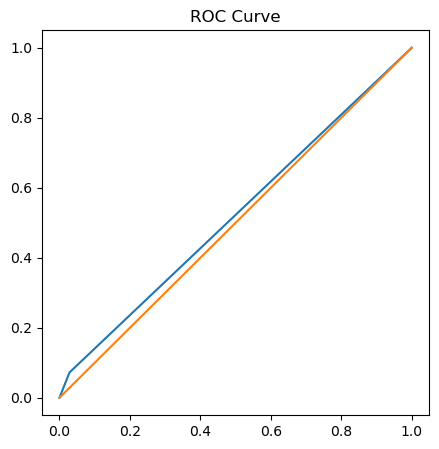

In [26]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(5,5))
plt.title('ROC Curve')
plt.plot(fpr, tpr)
plt.plot([0, 1], [0,1])
plt.show()

In [27]:
from sklearn.metrics import auc
auc(fpr, tpr)

0.5219246191267417

In [29]:
# Cross_Validation
kf = KFold(n_splits=10, shuffle=True, random_state=9)

logreg = LogisticRegression(solver='liblinear')
params = {"penalty": ["l1", "l2"],
         "tol": np.linspace(0.0001, 1.0, 50),
         "C": np.linspace(0.1, 1.0, 50),
         "class_weight": ["balanced", {0:0.8, 1:0.2}]}

# Instantiate the RandomizedSearchCV object
logreg_cv = RandomizedSearchCV(logreg, params, cv=kf)

# Fit the data to the model
logreg_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Best Accuracy Score: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'tol': 0.6326897959183674, 'penalty': 'l1', 'class_weight': {0: 0.8, 1: 0.2}, 'C': 0.9816326530612246}
Tuned Logistic Regression Best Accuracy Score: 0.799813432835821


In [53]:
model = logreg_cv.best_estimator_
y_val_pred = model.predict(X_val)

roc_auc_score(y_val, y_val_pred)

0.5